<a href="https://colab.research.google.com/github/GKSJ-Deepvision/AI-DeepVision/blob/Anvitha_Bolakonda/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import torch
import torch.nn as nn
from torchvision import models
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1,   1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# ⭐ Use your real checkpoint path here


WEIGHTS_PATH = Path(
    "/content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/partB_best.pth"
)

assert WEIGHTS_PATH.exists(), f"Weights not found: {WEIGHTS_PATH}"

model = CSRNet().to(device)
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✅ Loaded weights from:", WEIGHTS_PATH)


Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:02<00:00, 189MB/s]


✅ Loaded weights from: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/models/partB_best.pth


In [29]:
!pip install -q ultralytics==8.1.20 matplotlib gradio opencv-python

import os, cv2, tempfile, time, numpy as np, matplotlib.pyplot as plt
import gradio as gr
import torch

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
YOLO_MODEL = "yolov8n.pt"
OUT_W, OUT_H = 640, 480

print("Device:", DEVICE, "| Gradio:", gr.__version__)

# ---------------- SAFE LOAD YOLO ----------------
orig_load = torch.load
def _forced_load(*a, **k):
    k["weights_only"] = False
    return orig_load(*a, **k)
torch.load = _forced_load

from ultralytics import YOLO
yolo = YOLO(YOLO_MODEL)
torch.load = orig_load
print("YOLO loaded ✔")

# ------------- helper functions (UNCHANGED) -------------
def run_yolo(frame_rgb, conf=0.35):
    res = yolo.predict(
        source=frame_rgb,
        imgsz=(OUT_W, OUT_H),
        conf=conf,
        verbose=False,
        device=DEVICE
    )
    preds = res[0]
    boxes = []
    if getattr(preds, "boxes", None) is not None:
        for box, cls, confv in zip(
            preds.boxes.xyxy.cpu().numpy(),
            preds.boxes.cls.cpu().numpy(),
            preds.boxes.conf.cpu().numpy()
        ):
            if preds.names[int(cls)] != "person":
                continue
            x1, y1, x2, y2 = map(int, box[:4])
            boxes.append((x1, y1, x2, y2, float(confv)))
    return boxes

def annotate(frame_rgb, boxes, count):
    img = frame_rgb.copy()
    for (x1, y1, x2, y2, c) in boxes:
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, f"{c:.2f}", (x1, max(12,y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    cv2.putText(img, f"Count: {count}", (10,35),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    return img

# ---------------- NEW: Webcam processing (minimal add) ----------------
def process_webcam(frame, conf):
    if frame is None:
        return None

    frame = cv2.resize(frame, (OUT_W, OUT_H))
    boxes = run_yolo(frame, conf)
    count = len(boxes)
    out = annotate(frame, boxes, count)
    return out

# ---------------- Build Gradio UI (UPLOAD REMOVED) ----------------
with gr.Blocks() as demo:
    gr.HTML("<div style='font-size:26px; font-weight:700;'>Crowd Counting — Webcam Only</div>")
    gr.HTML("<div style='color:#9CA3AF;'>Upload option completely removed</div>")

    with gr.Row():
        with gr.Column(scale=2):
            webcam = gr.Image(
                sources=["webcam"],   # ✅ FIX HERE
                streaming=True,
                label="Webcam Input"
            )
            conf = gr.Slider(0.1, 0.9, value=0.35, label="YOLO Confidence")

        with gr.Column(scale=2):
            output = gr.Image(label="Live Output")

    webcam.stream(
        fn=process_webcam,
        inputs=[webcam, conf],
        outputs=output
    )

demo.launch(share=True)


Device: cuda | Gradio: 5.50.0
YOLO loaded ✔
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b58fd669bc6029d0bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [49]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FOUND PATH: /content/drive/MyDrive/DeepVisionMoniter/Deep Vision moniter/Output Task_1.png


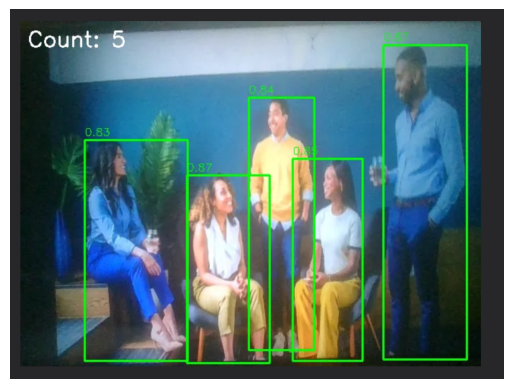

In [51]:
import os
from PIL import Image
import matplotlib.pyplot as plt

found = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if "Output Task_1.png" in files:
        found = os.path.join(root, "Output Task_1.png")
        break

print("FOUND PATH:", found)

if found is None:
    raise FileNotFoundError("Output Task_1.png not found anywhere in MyDrive")

img = Image.open(found)
plt.imshow(img)
plt.axis("off")
plt.show()
